In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [88]:
data_frame = pd.read_csv("./mnist_train.csv", sep=",", header=None)

In [89]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
scale=np.zeros(data_frame.shape[0])
for i in range (data_frame.shape[0]):
    scale [i]=np.max(data_frame.loc[i, 1:]) if np.max(data_frame.loc[i, 1:]) !=0 else 1


In [91]:
data=data_frame.as_matrix()

C:\Users\Paulina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [95]:
data=np.divide(data, scale.reshape([60000,1]))

In [96]:
image=data[0,1:].reshape((28,28))

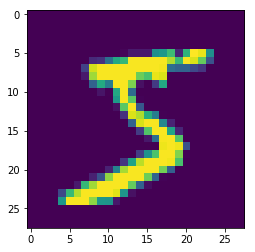

In [97]:
plt.imshow(image)
plt.show()

In [101]:
#create validation set
from sklearn.model_selection import train_test_split
train_data,val_data=train_test_split(data, test_size=0.2, random_state=42)

In [140]:
import numpy as np
from random import shuffle
from sklearn.metrics import mean_squared_error

class Network(object):
    
    def __init__(self, train_data, hidden_layer_neurons_num, epochs, learning_rate = 0.05):
        self.number_of_classes = 10
        self.epochs=epochs
        self.train_data = train_data
        self.learning_rate = learning_rate
        train_data_without_labels = train_data[:,1:]
        self.input_neurons_num = train_data_without_labels.shape[0] \
            if len(train_data_without_labels.shape) == 1 \
            else train_data_without_labels.shape[1]
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = [lambda x: self.sigmoid_function(x)] * (self.layers_num - 2) + \
            [lambda x: self.softmax_function(x)] 
        self.weight_list = [np.random.randn(next_layer_num, current_layer_num) \
                       for (current_layer_num, next_layer_num) in \
                            zip(self.neurons_num_per_layer, self.neurons_num_per_layer[1:])]
        self.bias_list = [np.random.randn(layer_num,1) for layer_num in self.neurons_num_per_layer[1:]]
        
    
    def main(self, batch_size):
        avg_mse=np.zeros(self.epochs) 
        avg_val=np.zeros(self.epochs) 
        for epoch in range(self.epochs):
            shuffle(self.train_data)
            train_batches = self.create_train_batches(batch_size)
            mse1=self.feed_forward(train_batches)
            avg_mse[epoch]=mse1/self.train_data.shape[0]
            mse_val=self.predict(val_data)
            avg_val[epoch]=mse_val/val_data.shape[0]
        return avg_mse, avg_val 
                

    #uwaga feedforward można zrobić macierzowo, ale backprop trzeba dla pojedynczych rekordów
    def feed_forward(self, train_batches):
        mse = 0
        for train_batch in train_batches:
            labels = self.one_hot_encoded(train_batch[:, 0:1])
            train_batch_features = train_batch[:, 1:]
            batch_size=train_batch_features.shape[0]
        
            #forward
            grad_w=[0] * (self.layers_num - 1)
            grad_b=[0] * (self.layers_num - 1)
            
            for i in range (len(train_batch)): #rekord
                u = []
                layer_output = [train_batch_features[i,:]]
                for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                    a=np.matmul(w,layer_output[-1])
                    u.append(a.reshape(a.shape[0], 1) + b)
                    layer_output.append(activation_function(u[-1]))
                
                mse+=mean_squared_error(layer_output[-1],labels[:,i].reshape(10,1))
                
                #backprop
                label=labels[:,i].reshape(10,1)
                delta = [(layer_output[-1] - label) * self.softmax_derivative(layer_output[-1], u[-1])] 
                for layer_num in reversed(range(1, self.layers_num-1)):
                    delta.append(np.matmul(self.weight_list[layer_num].T, delta[-1])*\
                                 self.sigmoid_derivative(u[layer_num-1])) 
                delta = list(reversed(delta))
            
                tmp_grad_w = [np.matmul(delta[0], train_batch_features[i,:].reshape(784,1).T)]
                for activ, d, _u in zip(self.activation_functions, delta[1:], u):
                    tmp_grad_w.append(np.matmul(d,activ(_u).T))
                    
                grad_w = [a + b for a, b in zip(grad_w, tmp_grad_w)]
                grad_b= [a + b for a, b in zip(delta, grad_b)]
                
            new_weight_list = [w - (self.learning_rate * gw / batch_size) \
                               for w, gw in zip(self.weight_list, grad_w)]
            self.weight_list = new_weight_list
            
            new_bias_list = [ b - (self.learning_rate * gb / batch_size) \
                             for b, gb in zip(self.bias_list, grad_b)]
            self.bias_list = new_bias_list
        return mse
    
    def predict(self, test_batch):
        labels = self.one_hot_encoded(test_batch[:, 0:1])
        test_batch_features = test_batch[:, 1:]
        batch_size=test_batch_features.shape[0]
        res = []
        diff=0
        for i in range(len(test_batch)):
            layer_output = test_batch_features[i,:]
            for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                a = np.matmul(w,layer_output)
                u = a.reshape(a.shape[0], 1) + b
                layer_output = activation_function(u)
    
            res.append(layer_output)
            #print("label: {0}".format((layer_output)))
            
            diff+=mean_squared_error(layer_output, labels[:,i])
        return diff
            
    def softmax_derivative(self, probabilities, u):
        diff_output=np.zeros([self.number_of_classes, self.number_of_classes])
        for row in range (diff_output.shape[0]):
            for col in range (diff_output.shape[1]):
                if (col==row):
                    diff_output[row,col]=probabilities[row,0]*(1-probabilities[col,0])
                else:
                    diff_output[row,col]=-probabilities[row,0]*probabilities[col,0]
        return np.matmul(diff_output,u)
                             
    def sigmoid_derivative(self, u):
        sigmoid_value = self.sigmoid_function(u)
        diff_output=sigmoid_value*(1-sigmoid_value)
        return diff_output
        
    def tanh_derivative(self, u):
        diff_output=1-(u)^2
        return diff_output
         
    def create_train_batches(self, batch_size):
        rows_num = self.train_data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [self.train_data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]
    
    def one_hot_encoded(self, train_labels):
        train_labels = train_labels.astype(int)
        res = np.zeros((self.number_of_classes, train_labels.shape[0]))
        res[train_labels, np.arange(res.shape[1])] = 1
        return res
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax_function(self, x):
        return np.exp(x) / np.sum(np.exp(x)) 
        


In [141]:
net = Network(train_data[1:4800,:], [100, 90], 30)

In [112]:
[matrix.shape for matrix in net.weight_list]

[(100, 784), (90, 100), (10, 90)]

In [113]:
net.input_neurons_num

784

In [114]:
net.bias_list[2].shape

(10, 1)

In [142]:
ms1,ms2 = net.main(128)

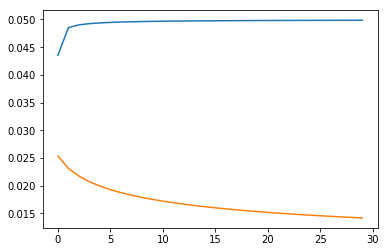

In [146]:
import matplotlib.pyplot as plt
plt.plot(ms1)
plt.plot(ms2)
plt.show()

In [ ]:
net.predict(val_data)